In [ ]:
import tensorflow as tf
tf . print(tf. __version__)

!git clone --quiet https://github.com/Ayma-n/Mask_RCNN.git

2.9.2


# Overview
This repo was taken from [here](https://www.immersivelimit.com/tutorials/using-mask-r-cnn-on-custom-coco-like-dataset)
and modified to accomodate training our model on our dataset.

At this point, if you are testing, go straight to the testing section (after running that code chunk above!)

In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.9.0 -y

Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.8/dist-packages/tensorflow-2.9.2.dist-info/*
    /usr/local/lib/python3.8/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.9.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 191 bytes/s 


In [ ]:
!unzip /content/new_data.zip



Archive:  /content/new_data.zip
   creating: new_data/
  inflating: new_data/.DS_Store      
  inflating: __MACOSX/new_data/._.DS_Store  
   creating: new_data/test/
  inflating: new_data/test.json      
  inflating: new_data/train.json     
   creating: new_data/train/
  inflating: new_data/test/176.png   
  inflating: new_data/test/88.png    
  inflating: new_data/test/162.png   
  inflating: new_data/test/189.png   
  inflating: new_data/test/77.png    
  inflating: new_data/test/63.png    
  inflating: new_data/test/200.png   
  inflating: new_data/test/62.png    
  inflating: new_data/test/188.png   
  inflating: new_data/test/76.png    
  inflating: new_data/test/163.png   
  inflating: new_data/test/177.png   
  inflating: new_data/test/89.png    
  inflating: new_data/test/149.png   
  inflating: new_data/test/161.png   
  inflating: new_data/test/175.png   
  inflating: new_data/test/60.png    
  inflating: new_data/test/74.png    
  inflating: new_data/test/48.png    
  infla

# Mask R-CNN Training and Inference
In this notebook we use Matterport's implementation of Mask R-CNN to train on a custom dataset, then use the trained weights to run inference on new images.

This is part of a tutorial posted at http://www.immersivelimit.com/tutorials/using-mask-r-cnn-on-custom-coco-like-dataset, so check there for more details.

### Not a beginner tutorial...
This is not intended to be a complete beginner tutorial.
- You should know how to clone a git repository from GitHub
- You should have a decent understanding of Python programming
- You should understand the basics of training deep neural networks. If you've never done it before, I wouldn't recommend starting here. Find a beginner deep learning tutorial/course and start there. There's lots of great free stuff on YouTube.

## **Download the Free Training Dataset First!
I've provided a free training dataset of cigarette butt images for use with this tutorial.
1. Download it from here: http://www.immersivelimit.com/datasets/cigarette-butts
2. Then extract the files and put it in the "../datasets" directory of this repo
3. The code below will be looking for "../datasets/cig_butts/train", "../datasets/cig_butts/val", and "../datasets/cig_butts/real_test"

In [ ]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

## Import Matterport's "mrcnn" libraries
1. I'm using a forked version of Matterport's Mask_RCNN git repo to make sure this code works, even if the main repo changes. As of July 29, 2018, there is a bug in Matterport's version that breaks loading an existing model that I've fixed in my version (and submitted a pull request to fix it in theirs).
  - My version is here: https://github.com/akTwelve/Mask_RCNN
  - The original is here: https://github.com/matterport/Mask_RCNN
2. Update the code cell below to point to the root directory of the repo on your machine.

In [ ]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '/content/Mask_RCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib


## Set up logging and pre-trained model paths
This will default to sub-directories in your mask_rcnn_dir, but if you want them somewhere else, updated it here.

It will also download the pre-trained coco model.

In [ ]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


## Configuration
Define configurations for training on the Cigarette Butt dataset.
### Note
These are settings that worked on my machine (GTX 970 graphics card). If you are getting OOM (Out of Memory) errors, you may need to tweak the settings or your computer may not be powerful enough. If you have a better graphics card, you will want to tweak it to take advantage of that.

In [ ]:
class CigButtsConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "letters"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 27 # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 1000

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 

    # ANH: I set this
    # IMAGE_META_SIZE = 65
    
config = CigButtsConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                39
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

# Define the dataset
I've attempted to make this generic to any COCO-like dataset. That means if you have another dataset defined in the COCO format, it should work.

In [ ]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids



# Create the Training and Validation Datasets
Make sure you download the training dataset linked at the top of this notebook. If you put the dataset somewhere else, update the paths below.

In [ ]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/content/new_data/train.json', '/content/new_data/train')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/content/new_data/test.json', '/content/new_data/test')
dataset_val.prepare()

## Display a few images from the training dataset

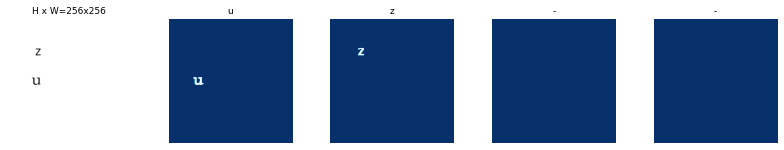

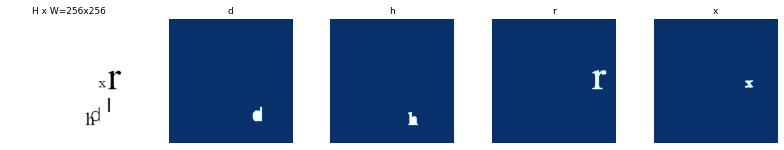

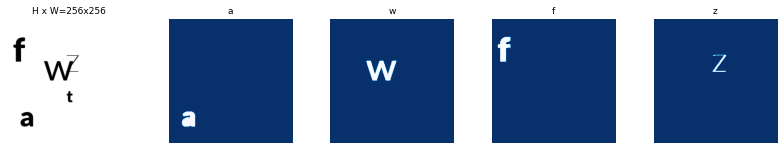

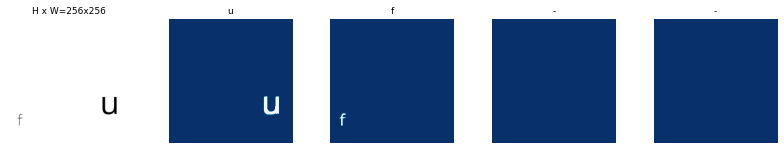

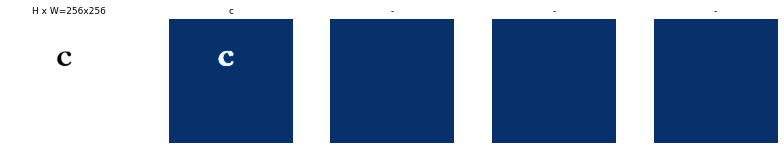

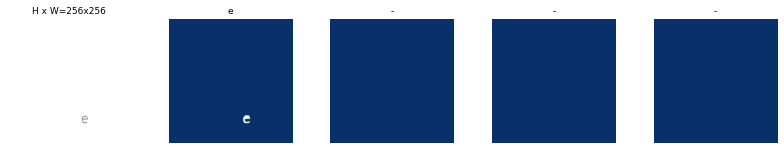

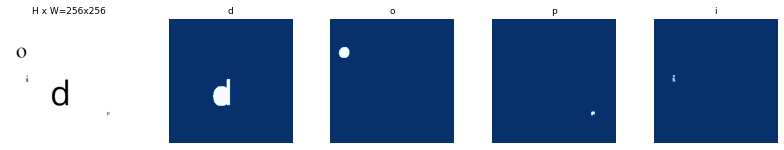

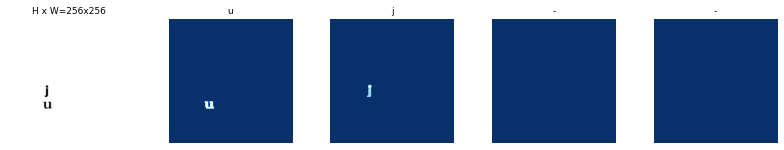

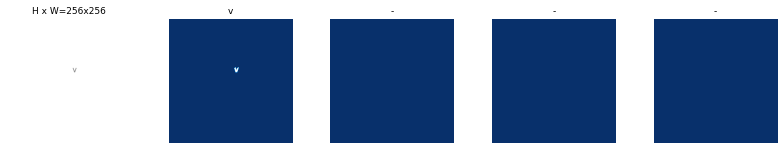

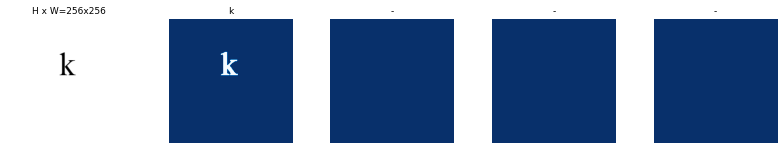

In [ ]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 10)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Create the Training Model and Train
This code is largely borrowed from the train_shapes.ipynb notebook.

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_width == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
!zip -r '/content/logs.zip' '/content/Mask_RCNN/logs/' 

updating: content/Mask_RCNN/logs/ (stored 0%)
  adding: content/Mask_RCNN/logs/letters20221213T2242/ (stored 0%)
  adding: content/Mask_RCNN/logs/letters20221213T2242/mask_rcnn_letters_0012.h5 (deflated 9%)
  adding: content/Mask_RCNN/logs/letters20221213T2242/mask_rcnn_letters_0013.h5 (deflated 9%)
  adding: content/Mask_RCNN/logs/letters20221213T2242/mask_rcnn_letters_0002.h5 (deflated 9%)
  adding: content/Mask_RCNN/logs/letters20221213T2242/mask_rcnn_letters_0005.h5 (deflated 9%)
  adding: content/Mask_RCNN/logs/letters20221213T2242/mask_rcnn_letters_0009.h5 (deflated 9%)
  adding: content/Mask_RCNN/logs/letters20221213T2242/mask_rcnn_letters_0016.h5 (deflated 9%)
  adding: content/Mask_RCNN/logs/letters20221213T2242/mask_rcnn_letters_0015.h5 (deflated 9%)
  adding: content/Mask_RCNN/logs/letters20221213T2242/mask_rcnn_letters_0018.h5 (deflated 9%)
  adding: content/Mask_RCNN/logs/letters20221213T2242/mask_rcnn_letters_0008.h5 (deflated 9%)
  adding: content/Mask_RCNN/logs/letters2

## Training

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.



In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/letters20221213T2242/mask_rcnn_letters_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv     

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 20. LR=0.0001

Checkpoint Path: /content/Mask_RCNN/logs/letters20221213T2242/mask_rcnn_letters_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_bran

In [ ]:
# loads weights from last time, DO NOT RUN THIS IF TRAINING FROM SCRATCH
!zip -r '/content/weights.zip' '/content/Mask_RCNN/logs/letters20221211T1647/mask_rcnn_letters_0021.h5'


In [ ]:
%load_ext tensorboard
import tensorflow as tf
tensorboard_callback =tf.keras.callbacks.TensorBoard('/content/Mask_RCNN/logs', histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# !pip uninstall tensorflow
!pip install tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.9.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
     |████████████████████████████████| 17.1 MB 5.8 MB/s 
     |████████████████████████████████| 438 kB 79.7 MB/s 
     |████████████████████████████████| 124 kB 80.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.15.0
    Uninstalling absl-py-0.15.0:
      Successfully uninstalled absl-py-0.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Th

In [ ]:
# start tensorboard for visualization

!tensorboard --logdir '/content/Mask_RCNN/logs'
from tensorboard import notebook
notebook.list()
notebook.display(port=6006, height=1000)

2022-12-13 23:50:58.593537: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C
No known TensorBoard instances running.


<IPython.core.display.Javascript object>

In [ ]:
from tensorboard import notebook
notebook.list()
notebook.display(port=6006, height=1000)

No known TensorBoard instances running.


<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

files.download('/content/weights.zip')

In [ ]:
# import weights into Google Drive
from google.colab import drive
drive.mount('/content/drive')
import shutil
shutil.copy("/content/weights.zip","/content/drive/MyDrive/")


In [ ]:
# import weights into Google Drive
from google.colab import drive
drive.mount('/content/drive')
import shutil
shutil.copy("/content/logs.zip","/content/drive/MyDrive/")

Mounted at /content/drive


'/content/drive/MyDrive/logs.zip'

# Testing - go here directly from start if model is trained!
Run 1st command at the start, then go here

In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.4.0 -y

Found existing installation: tensorflow 2.9.0
Uninstalling tensorflow-2.9.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.8/dist-packages/tensorflow-2.9.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.8 MB 41 kB/s 
     |████████████████████████████████| 132 kB 69.6 MB/s 
     |████████████████████████████████| 462 kB 80.5 MB/s 
     |████████████████████████████████| 3.8 MB 44.1 MB/s 
     |████████████████████████████████| 2.9 MB 61.7 MB/s 
     |████████████████████████████████| 14.9 MB 

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/MyDrive/cs1430_finalproj_data/weights.zip" "weights.zip"


In [ ]:
!unzip weights.zip

Archive:  weights.zip
   creating: content/
  inflating: __MACOSX/._content      
  inflating: content/.DS_Store       
  inflating: __MACOSX/content/._.DS_Store  
   creating: content/Mask_RCNN/
  inflating: __MACOSX/content/._Mask_RCNN  
  inflating: content/Mask_RCNN/.DS_Store  
  inflating: __MACOSX/content/Mask_RCNN/._.DS_Store  
   creating: content/Mask_RCNN/logs/
  inflating: __MACOSX/content/Mask_RCNN/._logs  
   creating: content/Mask_RCNN/logs/letters20221211T1647/
  inflating: __MACOSX/content/Mask_RCNN/logs/._letters20221211T1647  
  inflating: content/Mask_RCNN/logs/letters20221211T1647/mask_rcnn_letters_0021.h5  
  inflating: __MACOSX/content/Mask_RCNN/logs/letters20221211T1647/._mask_rcnn_letters_0021.h5  


# Prepare to run Inference
Create a new InferenceConfig, then use it to create a new model.

In [ ]:
# Rerun Configs for testing
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

In [ ]:
# Rerun Configs for testing
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '/content/Mask_RCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

In [ ]:
# Rerun Configs for testing
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file # OUR TRAINED WEIGHTS FILE
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
# Rerun Configs for testing
class CigButtsConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "letters"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 27 # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 1000

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

In [ ]:
class InferenceConfig(CigButtsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    DETECTION_MIN_CONFIDENCE = 0.90
    

inference_config = InferenceConfig()

In [ ]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = "/content/Mask_RCNN/logs/letters20221213T2242/mask_rcnn_letters_0020.h5"

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/Mask_RCNN/logs/letters20221213T2242/mask_rcnn_letters_0020.h5
Re-starting from epoch 20


# Run Inference
Run model.detect() on real images.

We get some false positives, and some misses. More training images are likely needed to improve the results.

In [ ]:
# Rerun Configs for testing
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids


In [ ]:
# Rerun Configs for testing
!unzip /content/new_data.zip

Archive:  /content/new_data.zip
replace new_data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Rerun Configs for testing
dataset_train = CocoLikeDataset()
dataset_train.load_data('/content/new_data/train.json', '/content/new_data/train')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/content/new_data/test.json', '/content/new_data/test')
dataset_val.prepare()

In [ ]:
# Variables to be passed onto postprocessing
final_char_ids = []
final_char_rois = []

In [ ]:
import skimage

img = skimage.io.imread("/content/test_word_pair_2.jpg")
img_arr = np.array(img)
print(img_arr[0,0,:])
results = model.detect([img_arr], verbose=1)
r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))

final_char_ids = r['class_ids']
final_char_rois = r['rois']

FileNotFoundError: ignored

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 39)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


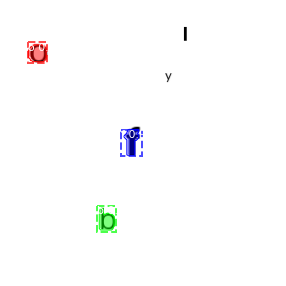

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 39)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32


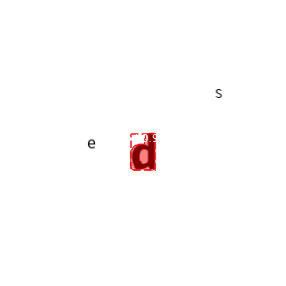

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 39)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32


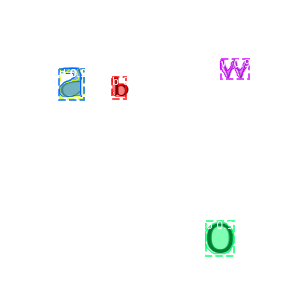

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 39)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32


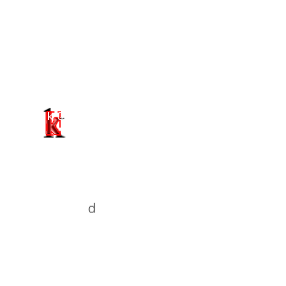

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 39)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32


KeyboardInterrupt: ignored

In [ ]:
import skimage
real_test_dir = '/content/new_data/test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))
    

In [ ]:
# test on words
import skimage
real_test_dir = '/content/word_data/test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))
    

# Processing letters into strings

Letter concatenation & word concatenation

In [ ]:
!pip install googletrans==3.1.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 1.5 MB 62.5 MB/s 
     |████████████████████████████████| 65 kB 4.1 MB/s 
     |████████████████████████████████| 53 kB 2.8 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16368 sha256=bba4ee4e9137346f302b1e7aec81c75554388137f52eb65f3afb891ed8508e6e
  Stored in directory: /root/.cache/pip/wheels/dd/59/af/8d6c96a719763990f1c548e36b17d9efdfb767f42f7ff39f53
Successfully built googletrans


In [ ]:
# import argparse
# import keras_ocr
# import matplotlib.pyplot as plt
from googletrans import Translator
from googletrans import constants
# import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
# from random import randint
from math import sqrt
import math

In [ ]:
def char_concat(char_ids, bounding_boxes):
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    charboxDict = {}
    for i in range(len(char_ids)):
        char_id = char_ids[i] - 1
        char = alphabet[char_id]
        char_bounding_box = bounding_boxes[i]
        # x & y are reversed in input
        char_tleft = (char_bounding_box[1], char_bounding_box[0])
        char_bright = (char_bounding_box[3], char_bounding_box[2])
        char_tright = (char_bright[0], char_tleft[1])
        char_bleft = (char_tleft[0], char_bright[1])
        key_tuple = (char, char_tleft, char_tright, char_bright, char_bleft)
        charboxDict[key_tuple] = 1
    print("charboxDict", charboxDict)

    char_size = len(charboxDict.keys())
    current_word_index = 0
    while current_word_index < char_size:
        textboxes = list(charboxDict.keys())
        current_textbox = textboxes[current_word_index]
        minDistance = math.inf
        closestTextbox = textboxes[0]
        closestTextboxIndex = 0
        for index, textbox in enumerate(textboxes):
            # if it's current word index, then skip
            if (index == current_word_index):
                continue
            # if it's not the current word, we process
            current_tright = current_textbox[2]
            index_tleft = textbox[1]
            # we find the closest text box TO THE RIGHT
            distance = sqrt((current_tright[0] - index_tleft[0])**2 + (current_tright[1] - index_tleft[1])**2)
            if (distance < minDistance):
                minDistance = distance
                closestTextbox = textbox
                closestTextboxIndex = index
        
        # after we have gotten the min distance:
        current_bright = current_textbox[3]
        current_tright = current_textbox[2]
        height = sqrt((current_bright[0] - current_tright[0])**2 + (current_bright[1] - current_tright[1])**2)
        em = height * 1.5
        closest_bleft = closestTextbox[4]
        closest_tleft = closestTextbox[1]
        closest_height = sqrt((closest_bleft[0] - closest_tleft[0])**2 + (closest_bleft[1] - closest_tleft[1])**2)
        if (minDistance < 0.5 * em and closest_height > height * 0.5 and closest_height < height * 1.5):
            # we connect this textbox with the closest textbox (to the right)
            closest_textbox_tright = closestTextbox[2]
            closest_textbox_bright = closestTextbox[3]
            current_bleft = current_textbox[4]
            current_tleft = current_textbox[1]
            connected_text = current_textbox[0] + closestTextbox[0]
            connected_textbox = (connected_text, current_tleft, closest_textbox_tright, closest_textbox_bright, current_bleft)

            # we pop out current textbox:
            charboxDict.pop(current_textbox)
            # decrease current_index & char_size:
            current_word_index -= 1
            char_size -= 1

            # we pop out closest textbox:
            charboxDict.pop(closestTextbox)
            # decrease current_index & char_size, ACCORDINGLY:
            if (current_word_index > closestTextboxIndex):
                current_word_index -= 1
            char_size -= 1

            # we add newest connected textbox:
            charboxDict[connected_textbox] = 1
            char_size += 1

        current_word_index += 1
    
    concatenated_chars = list(charboxDict.keys())
    return concatenated_chars # return words & bounding box

In [ ]:
# Concatenate letters into words
# final_char_ids = [ 2,  1,  2, 25]
# final_char_rois = [[ 80, 119, 109, 141],
#                   [ 87,  78, 108, 105],
#                   [ 81,  44, 112,  66],
#                   [ 85, 151, 120, 182]]
processed_words = char_concat(final_char_ids, final_char_rois)

charboxDict {('t', (83, 49), (102, 49), (102, 80), (83, 80)): 1, ('a', (175, 57), (198, 57), (198, 80), (175, 80)): 1, ('d', (143, 46), (162, 46), (162, 80), (143, 80)): 1, ('o', (51, 56), (79, 56), (79, 80), (51, 80)): 1, ('h', (21, 45), (41, 45), (41, 80), (21, 80)): 1, ('y', (203, 55), (230, 55), (230, 88), (203, 88)): 1}


In [ ]:
# Define path to image
prediction_image_path = '/content/test_word_pair_2.jpg'

In [ ]:
def overlay(detected_words, src_lang, dest_lang):
    # pipleline = keras_ocr.pipeline.Pipeline()
    # images = [keras_ocr.tools.read('test.png'), keras_ocr.tools.read('billboard.jpg')]
    # images = [keras_ocr.tools.read('test.png'), keras_ocr.tools.read(ARGS.img_path)]
    # print("ARGS.img_path", ARGS.img_path)

    # prediction_groups = pipleline.recognize(images)
    # fig, axs = plt.subplots(nrows=len(images), figsize=(10, 20))
    # for ax, image, predictions in zip(axs, images, prediction_groups):
    #     keras_ocr.tools.drawAnnotations(image=image, 
    #                                     predictions=predictions, 
    #                                     ax=ax)

    pillow_image = Image.open(prediction_image_path)
    # pillow_image = Image.open(ARGS.img_path)
    pillow_image = pillow_image.convert("RGBA")

    textboxDict = {}
    # for text, box in prediction_groups[1]:
    for text, text_tleft, text_tright, text_bright, text_bleft in detected_words:
        # text_tleft = (box[0][0], box[0][1])
        # text_tright = (box[1][0], box[1][1])
        # text_bright = (box[2][0], box[2][1])
        # text_bleft = (box[3][0], box[3][1]) # to calc height
        key_tuple = (text, text_tleft, text_tright, text_bright, text_bleft)
        textboxDict[key_tuple] = 1

    word_size = len(textboxDict.keys())
    current_word_index = 0
    while current_word_index < word_size:
        textboxes = list(textboxDict.keys())
        current_textbox = textboxes[current_word_index]
        minDistance = math.inf
        closestTextbox = textboxes[0]
        closestTextboxIndex = 0
        for index, textbox in enumerate(textboxes):
            # if it's current word index, then skip
            if (index == current_word_index):
                continue
            # if it's not the current word, we process
            current_tright = current_textbox[2]
            index_tleft = textbox[1]
            # we find the closest text box TO THE RIGHT
            distance = sqrt((current_tright[0] - index_tleft[0])**2 + (current_tright[1] - index_tleft[1])**2)
            if (distance < minDistance):
                minDistance = distance
                closestTextbox = textbox
                closestTextboxIndex = index
        
        # after we have gotten the min distance:
        current_bright = current_textbox[3]
        current_tright = current_textbox[2]
        height = sqrt((current_bright[0] - current_tright[0])**2 + (current_bright[1] - current_tright[1])**2)
        em = height * 1.5
        closest_bleft = closestTextbox[4]
        closest_tleft = closestTextbox[1]
        closest_height = sqrt((closest_bleft[0] - closest_tleft[0])**2 + (closest_bleft[1] - closest_tleft[1])**2)
        if (minDistance < 1.2 * em and closest_height > height * 0.5 and closest_height < height * 1.5):
            # we connect this textbox with the closest textbox (to the right)
            closest_textbox_tright = closestTextbox[2]
            closest_textbox_bright = closestTextbox[3]
            current_bleft = current_textbox[4]
            current_tleft = current_textbox[1]
            connected_text = current_textbox[0] + " " + closestTextbox[0]
            connected_textbox = (connected_text, current_tleft, closest_textbox_tright, closest_textbox_bright, current_bleft)

            # we pop out current textbox:
            textboxDict.pop(current_textbox)
            # decrease current_index & word_size:
            current_word_index -= 1
            word_size -= 1

            # we pop out closest textbox:
            textboxDict.pop(closestTextbox)
            # decrease current_index & word_size, ACCORDINGLY:
            if (current_word_index > closestTextboxIndex):
                current_word_index -= 1
            word_size -= 1

            # we add newest connected textbox:
            textboxDict[connected_textbox] = 1
            word_size += 1

        current_word_index += 1
    print("new textboxDict", textboxDict)

    concatenated_words = list(textboxDict.keys())
    # adding translation --------------------
    translate_client = Translator()
    all_text = [textbox[0] for textbox in concatenated_words]

    print("Original text in {}: {}".format(constants.LANGUAGES[src_lang], all_text))
    translation_list = translate_client.translate(all_text, src = src_lang, dest = dest_lang)
    translated_text_list = [text.text for text in translation_list]
    print("Translated text in {}: {}".format(constants.LANGUAGES[dest_lang], translated_text_list))
    
    # replace text with translation
    for index in range(len(concatenated_words)):
        list_textbox = list(concatenated_words[index])
        list_textbox[0] = translated_text_list[index]
        concatenated_words[index] = tuple(list_textbox)
    # adding translation --------------------

    for text, text_tleft, text_tright, text_bright, text_bleft in concatenated_words:
        # corners = np.array(box)
        tleft = text_tleft
        tright = text_tright
        bright = text_bright
        bleft = text_bleft
        width = int(sqrt((tright[0] - tleft[0])**2 + (tright[1] - tleft[1])**2))
        height = int(sqrt((tright[0] - bright[0])**2 + (tright[1] - bright[1])**2))
        overlay_img = Image.new('RGBA', (width, height), color='blue')
        # calculating font size -------------------------
        font_size = 1
        font = ImageFont.truetype("Lato-Regular.ttf", font_size)
        max_fraction = 0.90

        breakpoint = max_fraction * height
        jumpsize = 75
        while True:
            #print("hello")
            if font_size < breakpoint:
                font_size += jumpsize
                print(font_size)
            else:
                jumpsize = jumpsize // 2
                font_size -= jumpsize
            font = ImageFont.truetype("Lato-Regular.ttf", font_size)
            if jumpsize <= 1:
                break
        # calculating font size -------------------------
        imgDraw = ImageDraw.Draw(overlay_img)
        imgDraw.text((0, 0), text, fill=(255, 255, 0), font=font)

        # FOR SOME EDGE CASES, THIS APPROACH MIGHT NOT WORK
        current_vector = np.array([1,0])
        original_vector = np.array([tright[0] - tleft[0], tright[1] - tleft[1]])
        # normalizing original_vector
        original_vector = original_vector / np.linalg.norm(original_vector)
        # calculating the rotation angle # this angle is equal to the vertical angle
        theta = np.arccos(np.dot(current_vector, original_vector))
        # getting the height
        additional_height = np.sin(theta) * width
        # converting theta from radian to degree
        theta = np.degrees(theta)
        if (tleft[1] < tright[1]):
            theta = -theta
        rotated_overlay_img = overlay_img.rotate(theta, expand=True, resample=Image.BICUBIC, fillcolor=(0,0,0,0))
        pillow_image.paste(rotated_overlay_img, (int(tleft[0]), int(tleft[1] - additional_height)), mask=rotated_overlay_img)

    # pillow_image.show()
    display(pillow_image)

new textboxDict {('h ot day', (21, 45), (230, 55), (230, 88), (21, 80)): 1}
Original text in english: ['h ot day']
Translated text in french: ['journée chaude']
76
39
30
30


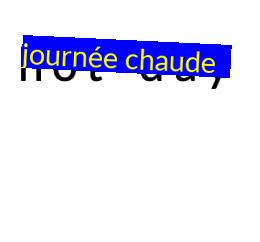

In [ ]:
overlay(processed_words, "en", "fr")